# Multi-Year WAR/162 Projection with Bat-Tracking Backfill

This notebook predicts **next-year WAR per 162 games (WAR/162)** from **current-year features**
using a multi-year hitter-by-year dataset:

`data/Hitters_2015-2025_byYear_retry.csv`

We build a year *t* → year *t+1* panel and compare three bat-tracking strategies:

A. `no_bat` – drop all bat-tracking features.
B. `median_impute` – keep bat-tracking features, impute missing values with the median.
C. `player_backfill` – for bat-tracking features, fill missing values for a player with that player's
   mean bat-tracking stats across all years where they exist (this uses information from other seasons
   for the same player and is optimistic / slightly leaky, but gives an upper bound on what bat tracking
   could add).

For each bat strategy we run two feature sets:

- `skill_only`: excludes current-year WAR and WAR_per_162 from features.
- `with_prev_war`: includes current-year WAR and WAR_per_162 as predictors.

Models:

- **ElasticNetCV** (regularized linear regression)
- **MLPRegressor** (feedforward neural net)


In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)


## 1. Load dataset and compute WAR_per_162

In [2]:
data_path = 'data/Hitters_2015-2025_byYear_retry.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
print('Columns (first 20):', list(df.columns)[:20])
print('\nSeason value counts:')
print(df['Season'].value_counts().sort_index())

df = df.copy()
df['WAR_per_162'] = (df['WAR'] / df['G'].replace(0, np.nan)) * 162
print('\nSample WAR_per_162 rows:')
print(df[['mlbID', 'Season', 'G', 'WAR', 'WAR_per_162']].head())


Shape: (7238, 86)
Columns (first 20): ['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF']

Season value counts:
Season
2015    694
2016    713
2017    699
2018    696
2019    712
2020    521
2021    717
2022    636
2023    618
2024    607
2025    625
Name: count, dtype: int64

Sample WAR_per_162 rows:
    mlbID  Season    G   WAR  WAR_per_162
0  547989    2015  154  3.35     3.524026
1  554429    2015  100 -0.89    -1.441800
2  542436    2015   24  0.04     0.270000
3  571431    2015   60  0.00     0.000000
4  501303    2015   49  0.15     0.495918


## 2. Build year *t* → year *t+1* panel

In [3]:
min_season, max_season = df['Season'].min(), df['Season'].max()
print('Seasons span:', min_season, 'to', max_season)

# t side: all but last season
df_t = df[df['Season'] < max_season].copy()

# t+1 target side
df_target = df[['mlbID', 'Season', 'WAR_per_162']].copy()
df_target = df_target.rename(columns={'Season': 'Season_next', 'WAR_per_162': 'WAR_per_162_next'})
df_target['Season'] = df_target['Season_next'] - 1

panel = df_t.merge(
    df_target[['mlbID', 'Season', 'Season_next', 'WAR_per_162_next']],
    on=['mlbID', 'Season'],
    how='inner'
)

print('Panel shape (t -> t+1 pairs):', panel.shape)
print('\nPairs by t (Season):')
print(panel['Season'].value_counts().sort_index())
print('\nPairs by t+1 (Season_next):')
print(panel['Season_next'].value_counts().sort_index())

panel = panel.dropna(subset=['WAR_per_162_next'])
print('\nPanel after dropping missing targets:', panel.shape)


Seasons span: 2015 to 2025
Panel shape (t -> t+1 pairs): (4992, 89)

Pairs by t (Season):
Season
2015    536
2016    529
2017    535
2018    545
2019    449
2020    448
2021    478
2022    491
2023    483
2024    498
Name: count, dtype: int64

Pairs by t+1 (Season_next):
Season_next
2016    536
2017    529
2018    535
2019    545
2020    449
2021    448
2022    478
2023    491
2024    483
2025    498
Name: count, dtype: int64

Panel after dropping missing targets: (4992, 89)


## 3. Identify bat-tracking feature columns

We heuristically detect bat-tracking columns by name (adjust as needed).

In [4]:
bat_kw = ['Name_bat','swings_competitive','percent_swings_competitive','contact','avg_bat_speed','hard_swing_rate','squared_up_per_bat_contact','squared_up_per_swing','blast_per_bat_contact','blast_per_swing','swing_length','swords','batter_run_value','whiffs','whiff_per_swing','batted_ball_events','batted_ball_event_per_swing']
all_cols = panel.columns.tolist()
bat_cols = []
for c in all_cols:
    lc = c.lower()
    if any(k in lc for k in bat_kw):
        bat_cols.append(c)

bat_cols = sorted(set(bat_cols))
bat_cols = [c for c in bat_cols if pd.api.types.is_numeric_dtype(panel[c])]
print('Detected bat-tracking numeric columns:', len(bat_cols))
print(bat_cols)


Detected bat-tracking numeric columns: 16
['avg_bat_speed', 'batted_ball_event_per_swing', 'batted_ball_events', 'batter_run_value', 'blast_per_bat_contact', 'blast_per_swing', 'contact', 'hard_swing_rate', 'percent_swings_competitive', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'swing_length', 'swings_competitive', 'swords', 'whiff_per_swing', 'whiffs']


## 4. Define base numeric features

We start with all numeric columns, excluding identifiers, year columns, and the t+1 target.

In [5]:
numeric_cols = panel.select_dtypes(include=[np.number]).columns.tolist()
exclude_base = {'mlbID', 'Season', 'Season_next', 'WAR_per_162_next'}
base_feature_cols = [c for c in numeric_cols if c not in exclude_base]
print('Base numeric feature columns (incl current-year WAR):', len(base_feature_cols))
print(base_feature_cols[:25])


Base numeric feature columns (incl current-year WAR): 76
['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'swings_competitive']


## 5. Train/test split

- **Train**: all pairs with `Season <= 2023` (predicting up through 2024).
- **Test**: pairs with `Season == 2024` (predicting 2025).

In [6]:
train_panel_raw = panel[panel['Season'] <= 2023].copy()
test_panel_raw = panel[panel['Season'] == 2024].copy()

print('Train panel (raw) shape:', train_panel_raw.shape)
print('Test panel  (raw) shape:', test_panel_raw.shape)


Train panel (raw) shape: (4494, 89)
Test panel  (raw) shape: (498, 89)


## 6. Player-level bat-tracking backfill (strategy C)

For bat-tracking columns, we create a **player-level mean** across all seasons where a player has
bat-tracking data, and use that mean to fill missing bat-tracking values for that player in other seasons.

In [7]:
panel_backfilled = panel.copy()
if bat_cols:
    # Compute per-player means on bat-tracking columns where they exist
    bat_means = panel.groupby('mlbID')[bat_cols].transform('mean')
    for c in bat_cols:
        panel_backfilled[c] = panel[c].fillna(bat_means[c])

train_panel_backfill = panel_backfilled[panel_backfilled['Season'] <= 2023].copy()
test_panel_backfill = panel_backfilled[panel_backfilled['Season'] == 2024].copy()

print('Train panel (backfilled) shape:', train_panel_backfill.shape)
print('Test panel  (backfilled) shape:', test_panel_backfill.shape)


Train panel (backfilled) shape: (4494, 89)
Test panel  (backfilled) shape: (498, 89)


## 7. Helper: run one experiment

We parameterize experiments by:

- `feature_mode`:
  - `'skill_only'`: drop current-year `WAR` and `WAR_per_162` from features.
  - `'with_prev_war'`: keep them as features.
- `bat_strategy`:
  - `'no_bat'`: drop bat-tracking columns from features.
  - `'median_impute'`: use raw panels, impute missing bat data with medians.
  - `'player_backfill'`: use backfilled panels, bat-tracking values already filled.


In [8]:
def run_experiment(train_panel, test_panel, base_feature_cols, bat_cols,
                   feature_mode='skill_only', bat_strategy='no_bat',
                   random_state=42):
    # Start from base features
    feature_cols = base_feature_cols.copy()

    # Feature set: skill only vs with previous WAR
    if feature_mode == 'skill_only':
        feature_cols = [c for c in feature_cols if c not in {'WAR', 'WAR_per_162'}]
    elif feature_mode == 'with_prev_war':
        pass
    else:
        raise ValueError(f'Unknown feature_mode: {feature_mode}')

    # Bat strategy: only `no_bat` changes feature set; the others are handled via which panel we pass in
    if bat_strategy == 'no_bat':
        feature_cols = [c for c in feature_cols if c not in bat_cols]
    elif bat_strategy in {'median_impute', 'player_backfill'}:
        # keep bat features (already in feature_cols)
        pass
    else:
        raise ValueError(f'Unknown bat_strategy: {bat_strategy}')

    # Drop rows with missing target just in case
    train_subset = train_panel.dropna(subset=['WAR_per_162_next']).copy()
    test_subset = test_panel.dropna(subset=['WAR_per_162_next']).copy()

    X_train = train_subset[feature_cols].values
    y_train = train_subset['WAR_per_162_next'].values
    X_test = test_subset[feature_cols].values
    y_test = test_subset['WAR_per_162_next'].values

    # Impute + scale
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    # ElasticNetCV
    elastic_cv = ElasticNetCV(
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        alphas=np.logspace(-3, 2, 20),
        cv=5,
        random_state=random_state,
        n_jobs=-1
    )
    elastic_cv.fit(X_train_scaled, y_train)
    y_train_pred_lr = elastic_cv.predict(X_train_scaled)
    y_test_pred_lr = elastic_cv.predict(X_test_scaled)

    lr_train_rmse = root_mean_squared_error(y_train, y_train_pred_lr)
    lr_test_rmse = root_mean_squared_error(y_test, y_test_pred_lr)
    lr_train_r2 = r2_score(y_train, y_train_pred_lr)
    lr_test_r2 = r2_score(y_test, y_test_pred_lr)

    # Neural net
    mlp = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        early_stopping=True,
        random_state=random_state
    )
    mlp.fit(X_train_scaled, y_train)
    y_train_pred_nn = mlp.predict(X_train_scaled)
    y_test_pred_nn = mlp.predict(X_test_scaled)

    nn_train_rmse = root_mean_squared_error(y_train, y_train_pred_nn)
    nn_test_rmse = root_mean_squared_error(y_test, y_test_pred_nn)
    nn_train_r2 = r2_score(y_train, y_train_pred_nn)
    nn_test_r2 = r2_score(y_test, y_test_pred_nn)

    return {
        'feature_mode': feature_mode,
        'bat_strategy': bat_strategy,
        'n_train': len(y_train),
        'n_test': len(y_test),
        'feature_count': len(feature_cols),
        'feature_names': feature_cols,
        'lr_train_rmse': lr_train_rmse,
        'lr_test_rmse': lr_test_rmse,
        'lr_train_r2': lr_train_r2,
        'lr_test_r2': lr_test_r2,
        'nn_train_rmse': nn_train_rmse,
        'nn_test_rmse': nn_test_rmse,
        'nn_train_r2': nn_train_r2,
        'nn_test_r2': nn_test_r2,
        'elastic_model': elastic_cv,
        'mlp_model': mlp,
        'y_test': y_test,
        'y_test_pred_lr': y_test_pred_lr,
        'y_test_pred_nn': y_test_pred_nn,
    }


## 8. Run experiments for A, B, C × feature modes

Bat strategies:

- A: `no_bat` (raw panels)
- B: `median_impute` (raw panels)
- C: `player_backfill` (backfilled panels)


In [9]:
feature_modes = ['skill_only', 'with_prev_war']
bat_strategies = ['no_bat', 'median_impute', 'player_backfill']

all_results = []

for fm in feature_modes:
    for bs in bat_strategies:
        print(f"\n=== Running: feature_mode={fm}, bat_strategy={bs} ===")
        if bs in ['no_bat', 'median_impute']:
            tp = train_panel_raw
            sp = test_panel_raw
        elif bs == 'player_backfill':
            tp = train_panel_backfill
            sp = test_panel_backfill
        else:
            raise ValueError(bs)

        res = run_experiment(tp, sp, base_feature_cols, bat_cols,
                             feature_mode=fm, bat_strategy=bs, random_state=42)
        all_results.append(res)

summary_rows = []
for r in all_results:
    summary_rows.append({
        'feature_mode': r['feature_mode'],
        'bat_strategy': r['bat_strategy'],
        'n_train': r['n_train'],
        'n_test': r['n_test'],
        'feature_count': r['feature_count'],
        'lr_test_rmse': r['lr_test_rmse'],
        'lr_test_r2': r['lr_test_r2'],
        'nn_test_rmse': r['nn_test_rmse'],
        'nn_test_r2': r['nn_test_r2'],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by='nn_test_r2', ascending=False)
summary_df



=== Running: feature_mode=skill_only, bat_strategy=no_bat ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.578e+00, tolerance: 3.225e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.999e+01, tolerance: 3.278e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 


=== Running: feature_mode=skill_only, bat_strategy=median_impute ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.132e+00, tolerance: 3.186e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.612e+01, tolerance: 3.186e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 


=== Running: feature_mode=skill_only, bat_strategy=player_backfill ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.200e+02, tolerance: 2.959e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.097e+03, tolerance: 2.959e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 


=== Running: feature_mode=with_prev_war, bat_strategy=no_bat ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e+00, tolerance: 2.959e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e+01, tolerance: 3.225e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 


=== Running: feature_mode=with_prev_war, bat_strategy=median_impute ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+02, tolerance: 3.278e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+02, tolerance: 3.278e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 


=== Running: feature_mode=with_prev_war, bat_strategy=player_backfill ===


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.101e+00, tolerance: 3.186e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e+03, tolerance: 3.186e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 

,feature_mode,bat_strategy,n_train,n_test,feature_count,lr_test_rmse,lr_test_r2,nn_test_rmse,nn_test_r2
3,with_prev_war,no_bat,4494,498,60,2.344719,0.296519,2.402248,0.261575
0,skill_only,no_bat,4494,498,58,2.443861,0.235770,2.473781,0.216943
4,with_prev_war,median_impute,4494,498,76,2.545588,0.170823,2.605788,0.131142
5,with_prev_war,player_backfill,4494,498,76,2.415256,0.253556,2.666259,0.090347
1,skill_only,median_impute,4494,498,74,2.639904,0.108242,2.700061,0.067137
2,skill_only,player_backfill,4494,498,74,2.512124,0.192481,2.716380,0.055827


## 9. Look at features from the best model

Pick the configuration with the best NN test R² and print the feature names it used.

In [10]:
best_idx = int(np.argmax([r['lr_test_r2'] for r in all_results]))
best_res = all_results[best_idx]

print('Best config:')
print(' feature_mode :', best_res['feature_mode'])
print(' bat_strategy :', best_res['bat_strategy'])
print(' lr_test_r2   :', best_res['lr_test_r2'])
print('\nFeatures used (best model):')
print(best_res['feature_names'])


Best config:
 feature_mode : with_prev_war
 bat_strategy : no_bat
 lr_test_r2   : 0.296518977786967

Features used (best model):
['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'year', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 'est_woba_minus_woba_diff', 'team_id', 'age', 'competitive_runs', 'bolts', 'hp_to_1b', 'sprint_speed', 'WAR', 'WAR_per_162']


## 10. Diagnostics: predicted vs actual for best NN configuration

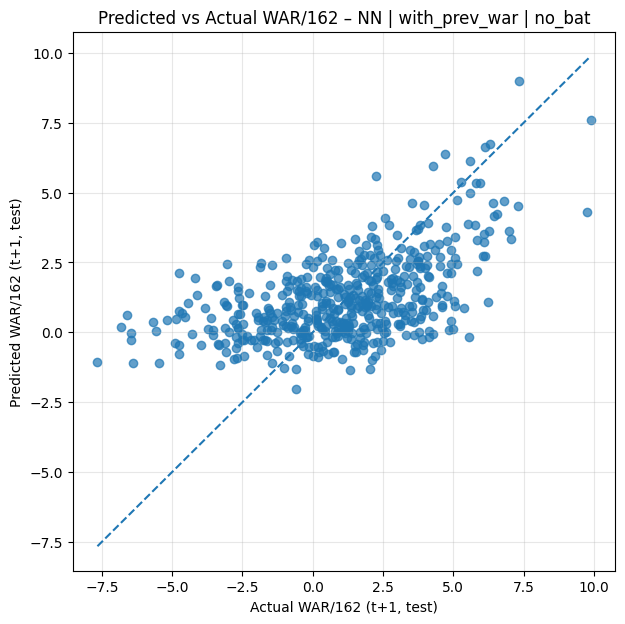

In [11]:
y_test = best_res['y_test']
y_pred = best_res['y_test_pred_lr']

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual WAR/162 (t+1, test)')
plt.ylabel('Predicted WAR/162 (t+1, test)')
plt.title(f"Predicted vs Actual WAR/162 – NN | {best_res['feature_mode']} | {best_res['bat_strategy']}")
plt.grid(True, alpha=0.3)
plt.show()


In [12]:
# Get the test panel data for the best model configuration
if best_res['bat_strategy'] == 'player_backfill':
    test_panel_used = test_panel_backfill
else:
    test_panel_used = test_panel_raw

# Get the subset that was actually used in testing (after dropping missing targets)
test_subset = test_panel_used.dropna(subset=['WAR_per_162_next']).copy()

# Create a results dataframe (include AB for qualifier analysis)
results_df = test_subset[['Name', 'mlbID', 'Season', 'Season_next', 'Age', 'G', 'PA', 'AB', 'WAR', 'WAR_per_162', 
                          'BA', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'BB', 'SO']].copy()

# Add predictions and errors
results_df['Actual_WAR_per_162_next'] = best_res['y_test']
results_df['Predicted_WAR_per_162_next'] = best_res['y_test_pred_lr']
results_df['Error'] = results_df['Predicted_WAR_per_162_next'] - results_df['Actual_WAR_per_162_next']
results_df['Abs_Error'] = results_df['Error'].abs()

# Sort by absolute error to find best and worst predictions
results_df_sorted = results_df.sort_values('Abs_Error')

print("=" * 80)
print("BEST PREDICTIONS (Smallest Errors)")
print("=" * 80)
print("\nTop 10 Best Predictions:\n")
best_10 = results_df_sorted.head(10)
for idx, row in best_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print()

print("\n" + "=" * 80)
print("WORST PREDICTIONS (Largest Errors)")
print("=" * 80)
print("\nTop 10 Worst Predictions:\n")
worst_10 = results_df_sorted.tail(10).iloc[::-1]  # Reverse to show worst first
for idx, row in worst_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print()


BEST PREDICTIONS (Smallest Errors)

Top 10 Best Predictions:

Bryce Harper              | Age 31 | Season 2024→2025
  Actual:     3.67 | Predicted:   3.66 | Error:  -0.01
  Year t:   WAR= 4.80, WAR/162= 5.22, OPS=0.907, HR=31

Zack Short                | Age 29 | Season 2024→2025
  Actual:    -0.15 | Predicted:  -0.13 | Error:   0.02
  Year t:   WAR=-0.10, WAR/162=-0.39, OPS=0.454, HR=0

CJ Abrams                 | Age 23 | Season 2024→2025
  Actual:     3.80 | Predicted:   3.83 | Error:   0.03
  Year t:   WAR= 3.37, WAR/162= 3.96, OPS=0.747, HR=20

Nick Martini              | Age 34 | Season 2024→2025
  Actual:    -0.83 | Predicted:  -0.86 | Error:  -0.03
  Year t:   WAR=-0.36, WAR/162=-1.17, OPS=0.641, HR=5

David Villar              | Age 27 | Season 2024→2025
  Actual:     0.18 | Predicted:   0.21 | Error:   0.03
  Year t:   WAR= 0.03, WAR/162= 0.44, OPS=0.727, HR=1

Jackson Merrill           | Age 21 | Season 2024→2025
  Actual:     3.75 | Predicted:   3.71 | Error:  -0.03
  Year 

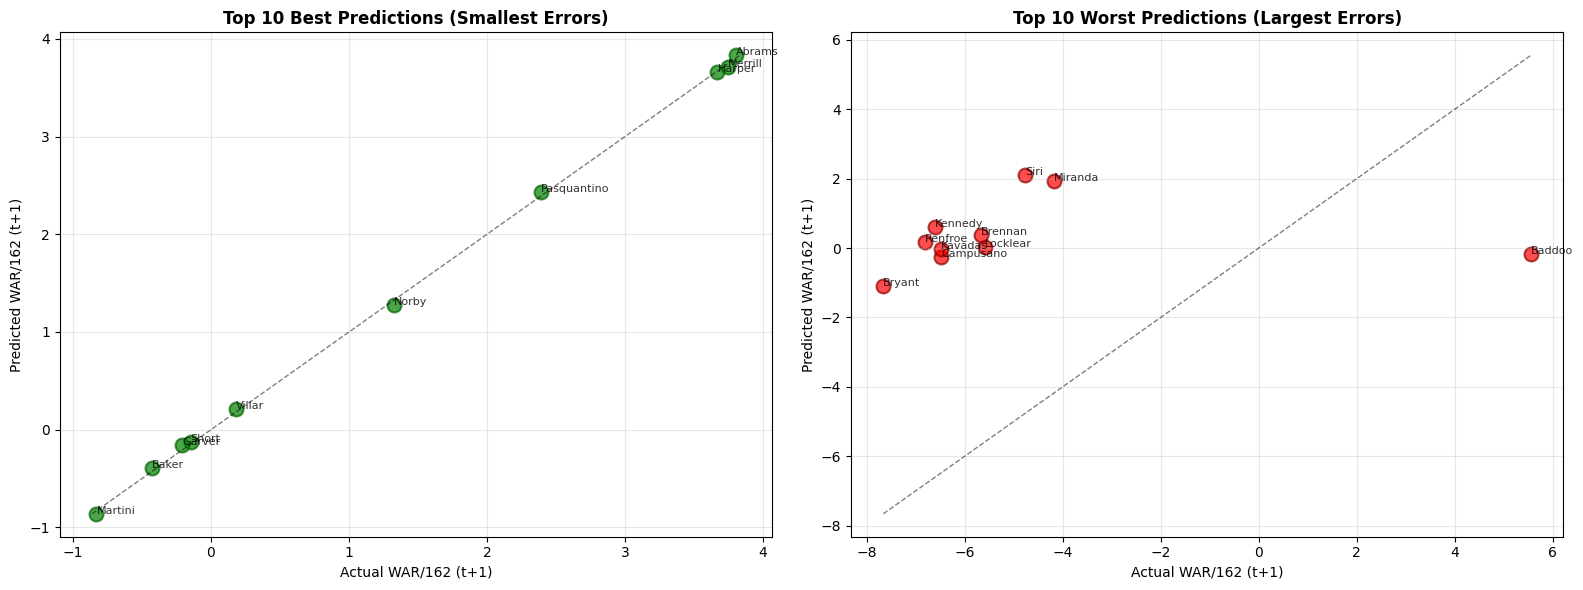


SUMMARY STATISTICS

Best 10 predictions:
  Mean absolute error: 0.034
  Mean error: 0.009

Worst 10 predictions:
  Mean absolute error: 6.382
  Mean error: 5.239

Overall test set:
  Mean absolute error: 1.857
  RMSE: 2.345


In [13]:
# Visualize best and worst predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Best predictions
ax1 = axes[0]
best_10 = results_df_sorted.head(10)
ax1.scatter(best_10['Actual_WAR_per_162_next'], best_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.7, color='green', edgecolors='darkgreen', linewidth=1.5)
for idx, row in best_10.iterrows():
    ax1.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=8, alpha=0.8)
lims1 = [min(best_10['Actual_WAR_per_162_next'].min(), best_10['Predicted_WAR_per_162_next'].min()),
         max(best_10['Actual_WAR_per_162_next'].max(), best_10['Predicted_WAR_per_162_next'].max())]
ax1.plot(lims1, lims1, 'k--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Actual WAR/162 (t+1)')
ax1.set_ylabel('Predicted WAR/162 (t+1)')
ax1.set_title('Top 10 Best Predictions (Smallest Errors)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Worst predictions
ax2 = axes[1]
worst_10 = results_df_sorted.tail(10)
ax2.scatter(worst_10['Actual_WAR_per_162_next'], worst_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.7, color='red', edgecolors='darkred', linewidth=1.5)
for idx, row in worst_10.iterrows():
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=8, alpha=0.8)
lims2 = [min(worst_10['Actual_WAR_per_162_next'].min(), worst_10['Predicted_WAR_per_162_next'].min()),
         max(worst_10['Actual_WAR_per_162_next'].max(), worst_10['Predicted_WAR_per_162_next'].max())]
ax2.plot(lims2, lims2, 'k--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Actual WAR/162 (t+1)')
ax2.set_ylabel('Predicted WAR/162 (t+1)')
ax2.set_title('Top 10 Worst Predictions (Largest Errors)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nBest 10 predictions:")
print(f"  Mean absolute error: {best_10['Abs_Error'].mean():.3f}")
print(f"  Mean error: {best_10['Error'].mean():.3f}")
print(f"\nWorst 10 predictions:")
print(f"  Mean absolute error: {worst_10['Abs_Error'].mean():.3f}")
print(f"  Mean error: {worst_10['Error'].mean():.3f}")
print(f"\nOverall test set:")
print(f"  Mean absolute error: {results_df['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((results_df['Error']**2).mean()):.3f}")


In [14]:
# Get PA/AB data for year t+1 (2025) to identify qualifiers
df_t1 = df[df['Season'] == 2025][['mlbID', 'Season', 'PA', 'AB', 'G']].copy()
df_t1 = df_t1.rename(columns={'PA': 'PA_next', 'AB': 'AB_next', 'G': 'G_next', 'Season': 'Season_next'})
df_t1['Season'] = df_t1['Season_next'] - 1  # Map back to year t for merging

# Merge with results_df to get t+1 PA/AB
results_df_with_t1 = results_df.merge(
    df_t1[['mlbID', 'Season', 'PA_next', 'AB_next', 'G_next']],
    on=['mlbID', 'Season'],
    how='left'
)

# Define qualifier thresholds (common thresholds: 300 PA or 400 AB for batting title)
min_pa = 300  # Minimum plate appearances
min_ab = 400  # Alternative: minimum at-bats

# Filter for qualifiers: must meet threshold in BOTH year t and year t+1
qualifiers_pa = results_df_with_t1[
    (results_df_with_t1['PA'] >= min_pa) & 
    (results_df_with_t1['PA_next'] >= min_pa)
].copy()

qualifiers_ab = results_df_with_t1[
    (results_df_with_t1['AB'] >= min_ab) & 
    (results_df_with_t1['AB_next'] >= min_ab)
].copy()

print("=" * 80)
print("QUALIFIER ANALYSIS")
print("=" * 80)
print(f"\nQualifier definition: >= {min_pa} PA in both 2024 and 2025")
print(f"Total test set size: {len(results_df_with_t1)}")
print(f"Qualifiers (PA >= {min_pa}): {len(qualifiers_pa)} ({100*len(qualifiers_pa)/len(results_df_with_t1):.1f}%)")
print(f"\nQualifier definition (alternative): >= {min_ab} AB in both 2024 and 2025")
print(f"Qualifiers (AB >= {min_ab}): {len(qualifiers_ab)} ({100*len(qualifiers_ab)/len(results_df_with_t1):.1f}%)")

# Calculate errors for qualifiers
qualifiers_pa['Error'] = qualifiers_pa['Predicted_WAR_per_162_next'] - qualifiers_pa['Actual_WAR_per_162_next']
qualifiers_pa['Abs_Error'] = qualifiers_pa['Error'].abs()
qualifiers_pa_sorted = qualifiers_pa.sort_values('Abs_Error')

print("\n" + "=" * 80)
print(f"QUALIFIER PERFORMANCE (>= {min_pa} PA in both seasons)")
print("=" * 80)
print(f"\nMean Absolute Error: {qualifiers_pa['Abs_Error'].mean():.3f}")
print(f"RMSE: {np.sqrt((qualifiers_pa['Error']**2).mean()):.3f}")
print(f"R²: {r2_score(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next']):.3f}")

print("\n" + "=" * 80)
print(f"BEST PREDICTIONS FOR QUALIFIERS (>= {min_pa} PA)")
print("=" * 80)
print("\nTop 10 Best Predictions:\n")
best_qual_10 = qualifiers_pa_sorted.head(10)
for idx, row in best_qual_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   PA={row['PA']:4.0f}, WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  Year t+1: PA={row['PA_next']:4.0f}")
    print()

print("\n" + "=" * 80)
print(f"WORST PREDICTIONS FOR QUALIFIERS (>= {min_pa} PA)")
print("=" * 80)
print("\nTop 10 Worst Predictions:\n")
worst_qual_10 = qualifiers_pa_sorted.tail(10).iloc[::-1]  # Reverse to show worst first
for idx, row in worst_qual_10.iterrows():
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  Actual:   {row['Actual_WAR_per_162_next']:6.2f} | Predicted: {row['Predicted_WAR_per_162_next']:6.2f} | Error: {row['Error']:6.2f}")
    print(f"  Year t:   PA={row['PA']:4.0f}, WAR={row['WAR']:5.2f}, WAR/162={row['WAR_per_162']:5.2f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  Year t+1: PA={row['PA_next']:4.0f}")
    print()


QUALIFIER ANALYSIS

Qualifier definition: >= 300 PA in both 2024 and 2025
Total test set size: 498
Qualifiers (PA >= 300): 205 (41.2%)

Qualifier definition (alternative): >= 400 AB in both 2024 and 2025
Qualifiers (AB >= 400): 123 (24.7%)

QUALIFIER PERFORMANCE (>= 300 PA in both seasons)

Mean Absolute Error: 1.459
RMSE: 1.800
R²: 0.318

BEST PREDICTIONS FOR QUALIFIERS (>= 300 PA)

Top 10 Best Predictions:

Bryce Harper              | Age 31 | Season 2024→2025
  Actual:     3.67 | Predicted:   3.66 | Error:  -0.01
  Year t:   PA= 648, WAR= 4.80, WAR/162= 5.22, OPS=0.907, HR=31
  Year t+1: PA= 598

CJ Abrams                 | Age 23 | Season 2024→2025
  Actual:     3.80 | Predicted:   3.83 | Error:   0.03
  Year t:   PA= 602, WAR= 3.37, WAR/162= 3.96, OPS=0.747, HR=20
  Year t+1: PA= 635

Jackson Merrill           | Age 21 | Season 2024→2025
  Actual:     3.75 | Predicted:   3.71 | Error:  -0.03
  Year t:   PA= 620, WAR= 4.44, WAR/162= 4.41, OPS=0.826, HR=25
  Year t+1: PA= 495

Vinni

In [15]:
# Add AB column to results_df if it's missing (needed for qualifier analysis)
if 'AB' not in results_df.columns:
    # Get the test panel data for the best model configuration
    if best_res['bat_strategy'] == 'player_backfill':
        test_panel_used = test_panel_backfill
    else:
        test_panel_used = test_panel_raw
    
    test_subset_for_ab = test_panel_used.dropna(subset=['WAR_per_162_next']).copy()
    ab_from_test = test_subset_for_ab[['mlbID', 'Season', 'AB']].copy()
    
    # Merge AB into results_df
    results_df = results_df.merge(
        ab_from_test[['mlbID', 'Season', 'AB']],
        on=['mlbID', 'Season'],
        how='left'
    )


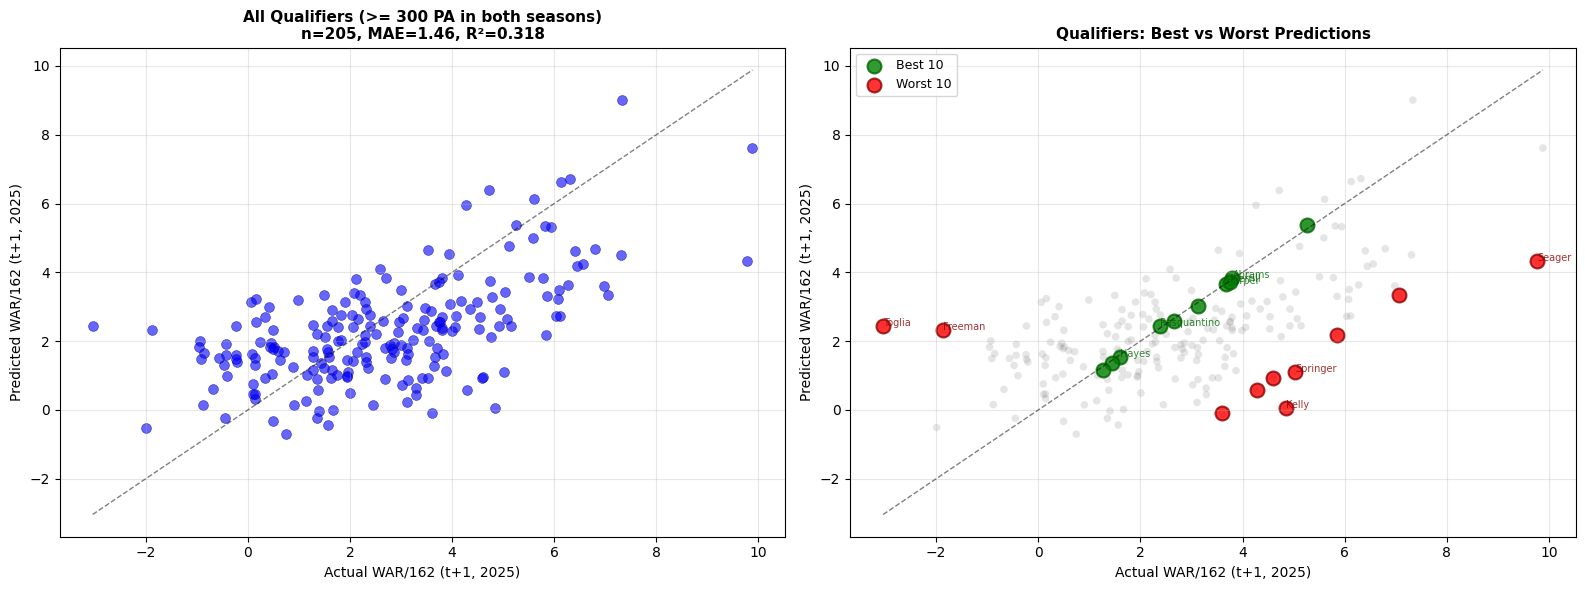


COMPARISON: QUALIFIERS vs NON-QUALIFIERS

Qualifiers (>= 300 PA in both seasons):
  Count: 205
  Mean Absolute Error: 1.459
  RMSE: 1.800
  R²: 0.318

Non-Qualifiers:
  Count: 293
  Mean Absolute Error: 2.136
  RMSE: 2.660
  R²: -0.050


In [16]:
# Visualize qualifier predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All qualifiers scatter plot
ax1 = axes[0]
ax1.scatter(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next'], 
            alpha=0.6, s=50, color='blue', edgecolors='darkblue', linewidth=0.5)
lims1 = [min(qualifiers_pa['Actual_WAR_per_162_next'].min(), qualifiers_pa['Predicted_WAR_per_162_next'].min()),
         max(qualifiers_pa['Actual_WAR_per_162_next'].max(), qualifiers_pa['Predicted_WAR_per_162_next'].max())]
ax1.plot(lims1, lims1, 'k--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Actual WAR/162 (t+1, 2025)')
ax1.set_ylabel('Predicted WAR/162 (t+1, 2025)')
ax1.set_title(f'All Qualifiers (>= {min_pa} PA in both seasons)\n' + 
              f'n={len(qualifiers_pa)}, MAE={qualifiers_pa["Abs_Error"].mean():.2f}, ' +
              f'R²={r2_score(qualifiers_pa["Actual_WAR_per_162_next"], qualifiers_pa["Predicted_WAR_per_162_next"]):.3f}',
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Best and worst qualifiers highlighted
ax2 = axes[1]
# Plot all qualifiers in light gray
ax2.scatter(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next'], 
            alpha=0.2, s=30, color='gray', edgecolors='none')
# Highlight best 10
ax2.scatter(best_qual_10['Actual_WAR_per_162_next'], best_qual_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.8, color='green', edgecolors='darkgreen', linewidth=1.5, label='Best 10')
# Highlight worst 10
ax2.scatter(worst_qual_10['Actual_WAR_per_162_next'], worst_qual_10['Predicted_WAR_per_162_next'], 
            s=100, alpha=0.8, color='red', edgecolors='darkred', linewidth=1.5, label='Worst 10')
# Annotate best and worst
for idx, row in best_qual_10.head(5).iterrows():  # Top 5 best
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=7, alpha=0.8, color='darkgreen')
for idx, row in worst_qual_10.head(5).iterrows():  # Top 5 worst
    ax2.annotate(row['Name'].split()[-1], 
                (row['Actual_WAR_per_162_next'], row['Predicted_WAR_per_162_next']),
                fontsize=7, alpha=0.8, color='darkred')
lims2 = [min(qualifiers_pa['Actual_WAR_per_162_next'].min(), qualifiers_pa['Predicted_WAR_per_162_next'].min()),
         max(qualifiers_pa['Actual_WAR_per_162_next'].max(), qualifiers_pa['Predicted_WAR_per_162_next'].max())]
ax2.plot(lims2, lims2, 'k--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Actual WAR/162 (t+1, 2025)')
ax2.set_ylabel('Predicted WAR/162 (t+1, 2025)')
ax2.set_title(f'Qualifiers: Best vs Worst Predictions', fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare qualifiers vs non-qualifiers
non_qualifiers = results_df_with_t1[
    ~((results_df_with_t1['PA'] >= min_pa) & (results_df_with_t1['PA_next'] >= min_pa))
].copy()
non_qualifiers['Error'] = non_qualifiers['Predicted_WAR_per_162_next'] - non_qualifiers['Actual_WAR_per_162_next']
non_qualifiers['Abs_Error'] = non_qualifiers['Error'].abs()

print("\n" + "=" * 80)
print("COMPARISON: QUALIFIERS vs NON-QUALIFIERS")
print("=" * 80)
print(f"\nQualifiers (>= {min_pa} PA in both seasons):")
print(f"  Count: {len(qualifiers_pa)}")
print(f"  Mean Absolute Error: {qualifiers_pa['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((qualifiers_pa['Error']**2).mean()):.3f}")
print(f"  R²: {r2_score(qualifiers_pa['Actual_WAR_per_162_next'], qualifiers_pa['Predicted_WAR_per_162_next']):.3f}")
print(f"\nNon-Qualifiers:")
print(f"  Count: {len(non_qualifiers)}")
print(f"  Mean Absolute Error: {non_qualifiers['Abs_Error'].mean():.3f}")
print(f"  RMSE: {np.sqrt((non_qualifiers['Error']**2).mean()):.3f}")
print(f"  R²: {r2_score(non_qualifiers['Actual_WAR_per_162_next'], non_qualifiers['Predicted_WAR_per_162_next']):.3f}")


## 13. Big WAR Jumps: Model Predictions vs Reality

Identify players who had significant WAR changes from 2024 to 2025 and see how well the model predicted those jumps.


In [17]:
# Calculate WAR change from 2024 to 2025
results_df_with_t1['WAR_change'] = results_df_with_t1['Actual_WAR_per_162_next'] - results_df_with_t1['WAR_per_162']
results_df_with_t1['Predicted_WAR_change'] = results_df_with_t1['Predicted_WAR_per_162_next'] - results_df_with_t1['WAR_per_162']
results_df_with_t1['Change_Error'] = results_df_with_t1['Predicted_WAR_change'] - results_df_with_t1['WAR_change']
results_df_with_t1['Abs_Change_Error'] = results_df_with_t1['Change_Error'].abs()

# Sort by absolute WAR change to find biggest jumps
results_df_with_t1_sorted = results_df_with_t1.sort_values('WAR_change', key=abs, ascending=False)

print("=" * 80)
print("BIGGEST WAR JUMPS FROM 2024 TO 2025")
print("=" * 80)

# Show top 20 biggest jumps (both positive and negative)
print("\nTop 20 Biggest WAR Changes (Positive and Negative):\n")
biggest_changes = results_df_with_t1_sorted.head(20)
for idx, row in biggest_changes.iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f} | Error: {row['Change_Error']:6.2f}")
    print()

# Focus on qualifiers with big jumps
qualifiers_with_t1 = results_df_with_t1[
    (results_df_with_t1['PA'] >= 300) & 
    (results_df_with_t1['PA_next'] >= 300)
].copy()
qualifiers_with_t1['WAR_change'] = qualifiers_with_t1['Actual_WAR_per_162_next'] - qualifiers_with_t1['WAR_per_162']
qualifiers_with_t1['Predicted_WAR_change'] = qualifiers_with_t1['Predicted_WAR_per_162_next'] - qualifiers_with_t1['WAR_per_162']
qualifiers_with_t1['Change_Error'] = qualifiers_with_t1['Predicted_WAR_change'] - qualifiers_with_t1['WAR_change']
qualifiers_with_t1_sorted = qualifiers_with_t1.sort_values('WAR_change', key=abs, ascending=False)

print("\n" + "=" * 80)
print("BIGGEST WAR JUMPS FOR QUALIFIERS (>= 300 PA in both seasons)")
print("=" * 80)

print("\nTop 15 Biggest WAR Changes for Qualifiers:\n")
qualifier_big_changes = qualifiers_with_t1_sorted.head(15)
for idx, row in qualifier_big_changes.iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f} | Error: {row['Change_Error']:6.2f}")
    print()

# Find cases where model predicted a big jump and it happened
print("\n" + "=" * 80)
print("CASES WHERE MODEL PREDICTED BIG JUMPS AND THEY HAPPENED")
print("=" * 80)

# Filter for cases where both predicted and actual changes are significant (>= 2.0 WAR)
predicted_big_jumps = results_df_with_t1[
    (results_df_with_t1['Predicted_WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['WAR_change'].abs() >= 2.0)
].copy()
predicted_big_jumps = predicted_big_jumps.sort_values('WAR_change', key=abs, ascending=False)

# Separate positive and negative jumps
positive_jumps = predicted_big_jumps[predicted_big_jumps['WAR_change'] > 0].sort_values('WAR_change', ascending=False)
negative_jumps = predicted_big_jumps[predicted_big_jumps['WAR_change'] < 0].sort_values('WAR_change', ascending=True)

print(f"\nTotal cases where model predicted big jump (>=2.0 WAR) and it happened: {len(predicted_big_jumps)}")
print(f"  Positive jumps (improvements): {len(positive_jumps)}")
print(f"  Negative jumps (declines): {len(negative_jumps)}")

print("\n" + "-" * 80)
print("POSITIVE JUMPS (Model Predicted Improvement and It Happened)")
print("-" * 80)
for idx, row in positive_jumps.iterrows():
    print(f"\n{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  WAR Change: ↑ {row['WAR_change']:5.2f} (Predicted: ↑ {row['Predicted_WAR_change']:5.2f})")
    print(f"  2024 Stats: WAR/162={row['WAR_per_162']:6.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}, BA={row['BA']:.3f}")
    print(f"  2025 Results: Actual={row['Actual_WAR_per_162_next']:6.2f} | Predicted={row['Predicted_WAR_per_162_next']:6.2f} | Error={row['Change_Error']:6.2f}")
    if pd.notna(row['PA_next']):
        print(f"  2025 PA: {row['PA_next']:.0f}")

print("\n" + "-" * 80)
print("NEGATIVE JUMPS (Model Predicted Decline and It Happened)")
print("-" * 80)
for idx, row in negative_jumps.iterrows():
    print(f"\n{row['Name']:25s} | Age {row['Age']:2.0f} | Season {row['Season']:.0f}→{row['Season_next']:.0f}")
    print(f"  WAR Change: ↓ {abs(row['WAR_change']):5.2f} (Predicted: ↓ {abs(row['Predicted_WAR_change']):5.2f})")
    print(f"  2024 Stats: WAR/162={row['WAR_per_162']:6.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}, HR={row['HR']:.0f}, BA={row['BA']:.3f}")
    print(f"  2025 Results: Actual={row['Actual_WAR_per_162_next']:6.2f} | Predicted={row['Predicted_WAR_per_162_next']:6.2f} | Error={row['Change_Error']:6.2f}")
    if pd.notna(row['PA_next']):
        print(f"  2025 PA: {row['PA_next']:.0f}")

# Find cases where model predicted a big jump but it didn't happen
print("\n" + "=" * 80)
print("CASES WHERE MODEL PREDICTED BIG JUMPS BUT THEY DIDN'T HAPPEN")
print("=" * 80)

predicted_but_not_actual = results_df_with_t1[
    (results_df_with_t1['Predicted_WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['WAR_change'].abs() < 1.0)
].copy()
predicted_but_not_actual = predicted_but_not_actual.sort_values('Predicted_WAR_change', key=abs, ascending=False)

print(f"\nPlayers where model predicted big jump (>=2.0 WAR) but actual change was small (<1.0 WAR):\n")
for idx, row in predicted_but_not_actual.head(10).iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | Predicted {row['Predicted_WAR_change']:6.2f}, Actual {row['WAR_change']:6.2f}")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print()

# Find cases where big jumps happened but model didn't predict them
print("\n" + "=" * 80)
print("CASES WHERE BIG JUMPS HAPPENED BUT MODEL DIDN'T PREDICT THEM")
print("=" * 80)

actual_but_not_predicted = results_df_with_t1[
    (results_df_with_t1['WAR_change'].abs() >= 2.0) &
    (results_df_with_t1['Predicted_WAR_change'].abs() < 1.0)
].copy()
actual_but_not_predicted = actual_but_not_predicted.sort_values('WAR_change', key=abs, ascending=False)

print(f"\nPlayers where big jump happened (>=2.0 WAR) but model predicted small change (<1.0 WAR):\n")
for idx, row in actual_but_not_predicted.head(10).iterrows():
    direction = "↑" if row['WAR_change'] > 0 else "↓"
    print(f"{row['Name']:25s} | Age {row['Age']:2.0f} | {direction} {abs(row['WAR_change']):5.2f} WAR")
    print(f"  2024: WAR/162={row['WAR_per_162']:5.2f}, PA={row['PA']:4.0f}, OPS={row['OPS']:.3f}")
    print(f"  2025: Actual={row['Actual_WAR_per_162_next']:5.2f} | Predicted={row['Predicted_WAR_per_162_next']:5.2f}")
    print(f"  Predicted Change: {row['Predicted_WAR_change']:6.2f} | Actual Change: {row['WAR_change']:6.2f}")
    print()


BIGGEST WAR JUMPS FROM 2024 TO 2025

Top 20 Biggest WAR Changes (Positive and Negative):

Nacho Alvarez Jr.         | Age 21 | ↑ 12.86 WAR
  2024: WAR/162=-10.73, PA=  32, OPS=0.256, HR=0
  2025: Actual= 2.12 | Predicted=-1.00
  Predicted Change:   9.73 | Actual Change:  12.86 | Error:  -3.12

Buddy Kennedy             | Age 25 | ↓  8.85 WAR
  2024: WAR/162= 2.24, PA=  26, OPS=0.689, HR=1
  2025: Actual=-6.60 | Predicted= 0.61
  Predicted Change:  -1.63 | Actual Change:  -8.85 | Error:   7.22

Rece Hinds                | Age 23 | ↓  8.83 WAR
  2024: WAR/162= 4.72, PA=  51, OPS=1.051, HR=5
  2025: Actual=-4.10 | Predicted= 1.32
  Predicted Change:  -3.41 | Actual Change:  -8.83 | Error:   5.42

Keston Hiura              | Age 27 | ↑  8.79 WAR
  2024: WAR/162=-9.40, PA=  27, OPS=0.296, HR=0
  2025: Actual=-0.61 | Predicted=-1.30
  Predicted Change:   8.10 | Actual Change:   8.79 | Error:  -0.69

Bryce Teodosio            | Age 25 | ↑  8.65 WAR
  2024: WAR/162=-7.13, PA=  12, OPS=0.167, H

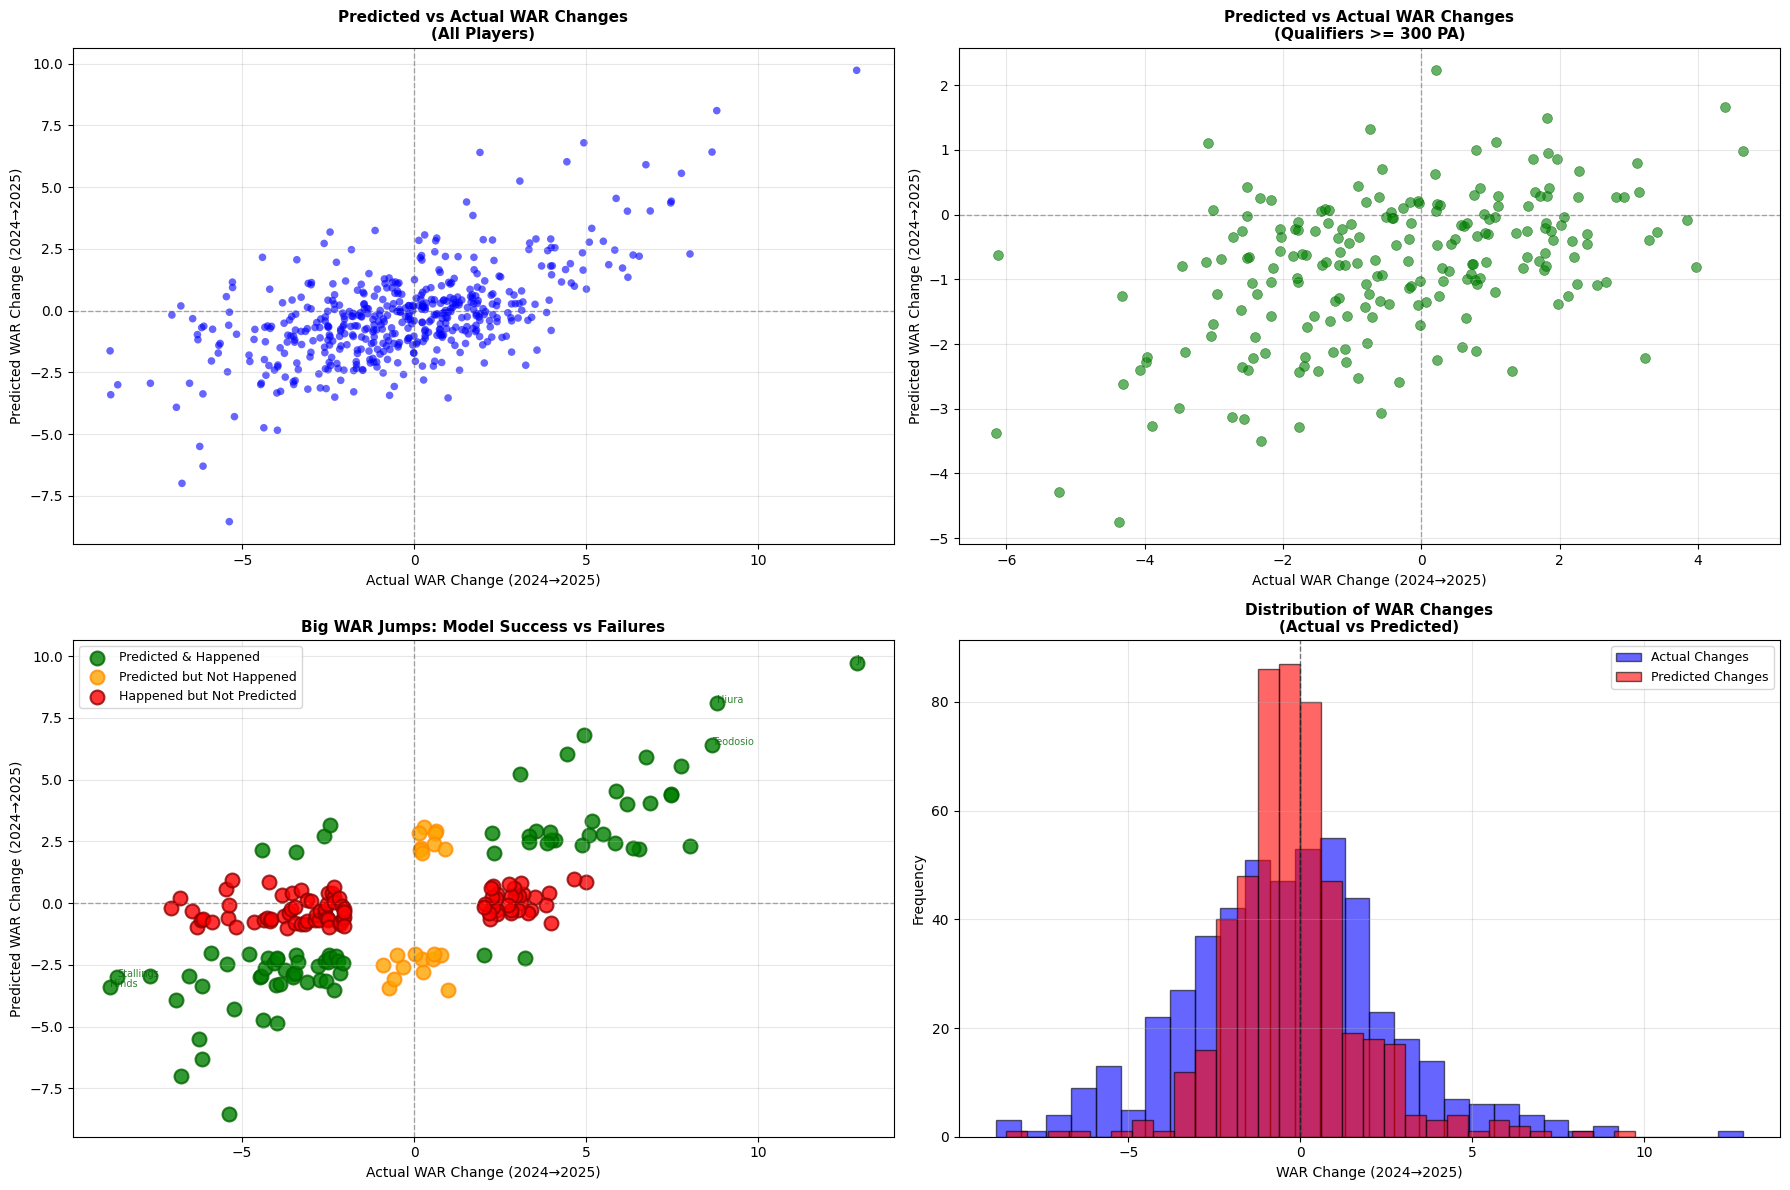


SUMMARY: BIG WAR JUMPS ANALYSIS

Total players analyzed: 498
Qualifiers analyzed: 205

Players with big actual jumps (>=2.0 WAR): 228
Players with big predicted jumps (>=2.0 WAR): 121

Model correctly predicted big jumps: 80
Model predicted big jumps that didn't happen: 21
Big jumps that model missed: 89

Correlation between predicted and actual changes: 0.618
Correlation for qualifiers: 0.486


In [18]:
# Visualize big WAR jumps
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Predicted vs Actual WAR changes (all players)
ax1 = axes[0, 0]
ax1.scatter(results_df_with_t1['WAR_change'], results_df_with_t1['Predicted_WAR_change'], 
            alpha=0.6, s=30, color='blue', edgecolors='none')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_xlabel('Actual WAR Change (2024→2025)')
ax1.set_ylabel('Predicted WAR Change (2024→2025)')
ax1.set_title('Predicted vs Actual WAR Changes\n(All Players)', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual WAR changes (qualifiers only)
ax2 = axes[0, 1]
ax2.scatter(qualifiers_with_t1['WAR_change'], qualifiers_with_t1['Predicted_WAR_change'], 
            alpha=0.6, s=50, color='green', edgecolors='darkgreen', linewidth=0.5)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax2.set_xlabel('Actual WAR Change (2024→2025)')
ax2.set_ylabel('Predicted WAR Change (2024→2025)')
ax2.set_title('Predicted vs Actual WAR Changes\n(Qualifiers >= 300 PA)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Highlight cases where model predicted big jumps correctly
ax3 = axes[1, 0]
if len(predicted_big_jumps) > 0:
    ax3.scatter(predicted_big_jumps['WAR_change'], predicted_big_jumps['Predicted_WAR_change'], 
                s=100, alpha=0.8, color='green', edgecolors='darkgreen', linewidth=1.5, 
                label='Predicted & Happened')
    for idx, row in predicted_big_jumps.head(5).iterrows():
        ax3.annotate(row['Name'].split()[-1], 
                    (row['WAR_change'], row['Predicted_WAR_change']),
                    fontsize=7, alpha=0.8, color='darkgreen')
if len(predicted_but_not_actual) > 0:
    ax3.scatter(predicted_but_not_actual['WAR_change'], predicted_but_not_actual['Predicted_WAR_change'], 
                s=100, alpha=0.8, color='orange', edgecolors='darkorange', linewidth=1.5,
                label='Predicted but Not Happened')
if len(actual_but_not_predicted) > 0:
    ax3.scatter(actual_but_not_predicted['WAR_change'], actual_but_not_predicted['Predicted_WAR_change'], 
                s=100, alpha=0.8, color='red', edgecolors='darkred', linewidth=1.5,
                label='Happened but Not Predicted')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax3.axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax3.set_xlabel('Actual WAR Change (2024→2025)')
ax3.set_ylabel('Predicted WAR Change (2024→2025)')
ax3.set_title('Big WAR Jumps: Model Success vs Failures', fontsize=11, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Distribution of WAR changes
ax4 = axes[1, 1]
ax4.hist(results_df_with_t1['WAR_change'], bins=30, alpha=0.6, color='blue', label='Actual Changes', edgecolor='black')
ax4.hist(results_df_with_t1['Predicted_WAR_change'], bins=30, alpha=0.6, color='red', label='Predicted Changes', edgecolor='black')
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
ax4.set_xlabel('WAR Change (2024→2025)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of WAR Changes\n(Actual vs Predicted)', fontsize=11, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY: BIG WAR JUMPS ANALYSIS")
print("=" * 80)
print(f"\nTotal players analyzed: {len(results_df_with_t1)}")
print(f"Qualifiers analyzed: {len(qualifiers_with_t1)}")
print(f"\nPlayers with big actual jumps (>=2.0 WAR): {len(results_df_with_t1[results_df_with_t1['WAR_change'].abs() >= 2.0])}")
print(f"Players with big predicted jumps (>=2.0 WAR): {len(results_df_with_t1[results_df_with_t1['Predicted_WAR_change'].abs() >= 2.0])}")
print(f"\nModel correctly predicted big jumps: {len(predicted_big_jumps)}")
print(f"Model predicted big jumps that didn't happen: {len(predicted_but_not_actual)}")
print(f"Big jumps that model missed: {len(actual_but_not_predicted)}")
print(f"\nCorrelation between predicted and actual changes: {results_df_with_t1['Predicted_WAR_change'].corr(results_df_with_t1['WAR_change']):.3f}")
print(f"Correlation for qualifiers: {qualifiers_with_t1['Predicted_WAR_change'].corr(qualifiers_with_t1['WAR_change']):.3f}")


## 14. Save Best Model for Roster Optimizer

Save the best model (ElasticNet with `with_prev_war`) along with preprocessing objects for use in the roster optimizer.


In [19]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Get the best model's feature columns (with_prev_war, no_bat)
best_feature_mode = best_res['feature_mode']
best_bat_strategy = best_res['bat_strategy']
best_feature_cols = best_res['feature_names']

# Retrain with the best configuration to get preprocessing objects
if best_bat_strategy in ['no_bat', 'median_impute']:
    train_p = train_panel_raw
else:
    train_p = train_panel_backfill

feature_cols = best_feature_cols.copy()
train_subset = train_p.dropna(subset=['WAR_per_162_next']).copy()

X_train = train_subset[feature_cols].values
y_train = train_subset['WAR_per_162_next'].values

# Fit imputer and scaler
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_imp)

# Train final model
final_model = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
    alphas=np.logspace(-3, 2, 20),
    cv=5,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_scaled, y_train)

# Save everything
model_artifacts = {
    'model': final_model,
    'imputer': imputer,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'feature_mode': best_feature_mode,
    'bat_strategy': best_bat_strategy,
}

joblib.dump(model_artifacts, 'models/hitter_war_model.joblib')
print(f"Saved hitter WAR model to 'models/hitter_war_model.joblib'")
print(f"  Feature mode: {best_feature_mode}")
print(f"  Bat strategy: {best_bat_strategy}")
print(f"  Features ({len(feature_cols)}): {feature_cols[:10]}...")


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.919e+00, tolerance: 3.204e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e+01, tolerance: 3.225e+00
  model = cd_fast.enet_coordinate_descent_gram(
/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number 

Saved hitter WAR model to 'models/hitter_war_model.joblib'
  Feature mode: with_prev_war
  Bat strategy: no_bat
  Features (60): ['Age', '#days', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR']...


/Users/drewtufto/15.571/project/6c571-project/ven/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.277e+00, tolerance: 3.963e+00
  model = cd_fast.enet_coordinate_descent(
